# Spaceship Titanic Kaggle Competition, by [Andres Perez](https://www.andresperez.info/)
[README](./README.md)

## Imports

In [2]:
# Data wrangling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling tools
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier

## Read in the Data

In [3]:
train = pd.read_csv('./data/train.csv')
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
test = pd.read_csv('./data/test.csv')
test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


## EDA
Using this notebook as a guide: [Geunho](https://www.kaggle.com/code/arootda/pycaret-visualization-optimization-0-81/data)

### Combine Train and Test data for EDA

In [6]:
data = pd.concat([train, test])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12970 entries, 0 to 4276
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12682 non-null  object 
 2   CryoSleep     12660 non-null  object 
 3   Cabin         12671 non-null  object 
 4   Destination   12696 non-null  object 
 5   Age           12700 non-null  float64
 6   VIP           12674 non-null  object 
 7   RoomService   12707 non-null  float64
 8   FoodCourt     12681 non-null  float64
 9   ShoppingMall  12664 non-null  float64
 10  Spa           12686 non-null  float64
 11  VRDeck        12702 non-null  float64
 12  Name          12676 non-null  object 
 13  Transported   8693 non-null   object 
dtypes: float64(6), object(8)
memory usage: 1.5+ MB


### Missing values

In [7]:
# Percentages of missing data
(data.isna().sum() / len(data)) * 100

PassengerId      0.000000
HomePlanet       2.220509
CryoSleep        2.390131
Cabin            2.305320
Destination      2.112567
Age              2.081727
VIP              2.282190
RoomService      2.027756
FoodCourt        2.228219
ShoppingMall     2.359291
Spa              2.189668
VRDeck           2.066307
Name             2.266769
Transported     32.976099
dtype: float64

Small amount of missing values, but filling them is better than dropping. Numericals will probably be filled with means, categoricals with modes. I have read in other notebooks that missing values in the spending categories can be correlated with CryoSleep category.

### Identify feature types

- Categorical: PassengerId, HomePlanet, CryoSleep, Cabin, Destination, VIP, Name
- Numerical: Age, RoomService, FoodCourt, ShoppingMall, Spa, VRDeck
- Target: Transported

In [8]:
data.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

In [9]:
# Build lists of features by type for easy panda df usage. Borrowed idea from Geunho
categoricals = [
    "PassengerId",
    "HomePlanet",
    "CryoSleep",
    "Cabin",
    "Destination",
    "VIP",
    "Name",
]

numericals = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

target = "Transported"


In [10]:
# Descriptive Statistics for numerical features
data[numericals].describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,12700.000000,12707.000000,12681.000000,12664.000000,12686.000000,12702.000000
mean,28.771969,222.897852,451.961675,174.906033,308.476904,306.789482
std,14.387261,647.596664,1584.370747,590.558690,1130.279641,1180.097223
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,49.000000,77.000000,29.000000,57.000000,42.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


### Explore Feature Distributions

#### Target Variable: Transported

Our target is categorical True/False. Check distribution to make sure it's balanced

''

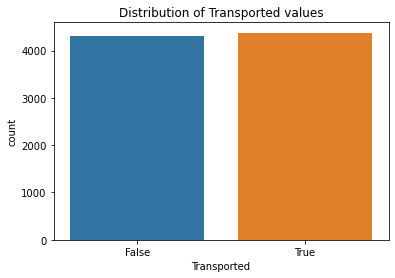

In [11]:
# Plot target distribution to verify balanced data
sns.countplot(data=data["Transported"], x=data["Transported"])
plt.title('Distribution of Transported values')
;

#### Categorical Features

In [12]:
categoricals

['PassengerId',
 'HomePlanet',
 'CryoSleep',
 'Cabin',
 'Destination',
 'VIP',
 'Name']

#### PassengerId

Passenger groups are hidden in the first four characters of this feature. Will use to create a IsFamily feature.

In [57]:
# Create IsFamily feature by mapping groups with more than one member. Can be refined by checking last names.
tmp = data.copy()
tmp['IsFamily'] = tmp['PassengerId'].apply(lambda x: 1 if int(str(x)[5:]) > 1 else 0)
tmp.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,IsFamily
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,1
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0


''

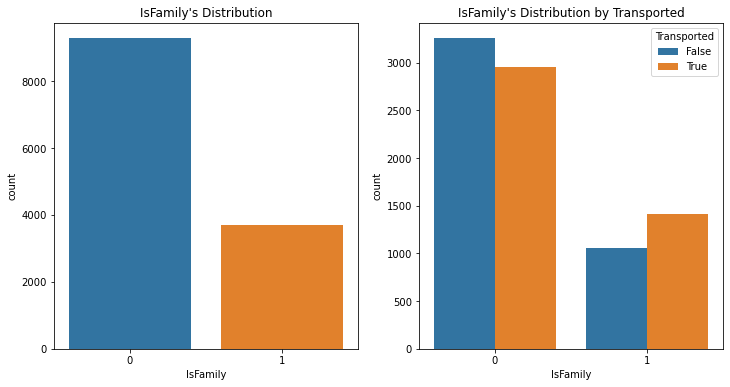

In [58]:
# Plot distribution and distribution by target. With help from Geunho's functions
feature = 'IsFamily'
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title(f"{feature}'s Distribution")
sns.countplot(
    data=tmp,
    x=tmp[feature],
)
plt.subplot(1, 2, 2)
plt.title(f"{feature}'s Distribution by Transported")
sns.countplot(
    data=tmp,
    x=tmp[feature],
    hue='Transported',
)
;

#### HomePlanet

''

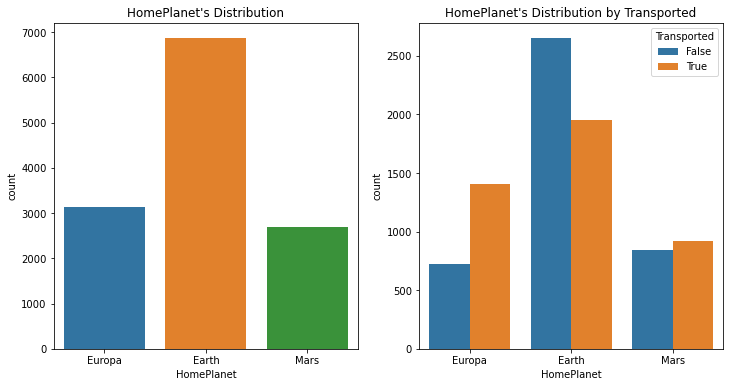

In [29]:
# Plot HomePlanet distribution and distribution by target. With help from Geunho's functions
feature = 'HomePlanet'
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title(f"{feature}'s Distribution")
sns.countplot(
    data=data,
    x=data[feature],
)
plt.subplot(1, 2, 2)
plt.title(f"{feature}'s Distribution by Transported")
sns.countplot(
    data=data,
    x=data[feature],
    hue='Transported',
)
;

#### CryoSleep

''

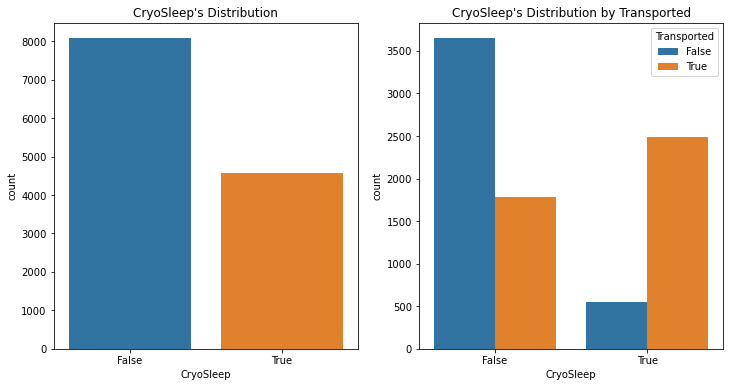

In [30]:
# Plot distribution and distribution by target. With help from Geunho's functions
feature = 'CryoSleep'
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title(f"{feature}'s Distribution")
sns.countplot(
    data=data,
    x=data[feature],
)
plt.subplot(1, 2, 2)
plt.title(f"{feature}'s Distribution by Transported")
sns.countplot(
    data=data,
    x=data[feature],
    hue='Transported',
)
;

#### Cabin

Too many cabins for this plot to be useful. Will separate cabin feature by deck/number/side.

In [38]:
# Create Deck, Number and Side features from Cabin. Use temporary copy of data
tmp = data.copy()
tmp['Deck'] = tmp['Cabin'].apply(lambda x: str(x)[0])
tmp['Number'] = tmp['Cabin'].apply(lambda x: str(x)[2])
tmp['Side'] = tmp['Cabin'].apply(lambda x: str(x)[-1])
tmp.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Number,Side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1,S


''

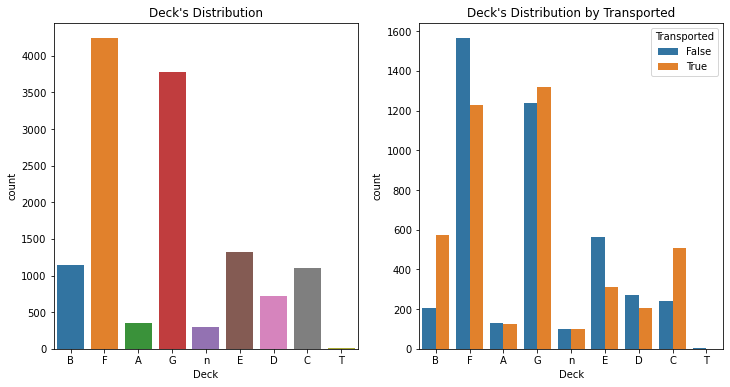

In [39]:
# Plot distribution and distribution by target. With help from Geunho's functions
feature = 'Deck'
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title(f"{feature}'s Distribution")
sns.countplot(
    data=tmp,
    x=tmp[feature],
)
plt.subplot(1, 2, 2)
plt.title(f"{feature}'s Distribution by Transported")
sns.countplot(
    data=tmp,
    x=tmp[feature],
    hue='Transported',
)
;

''

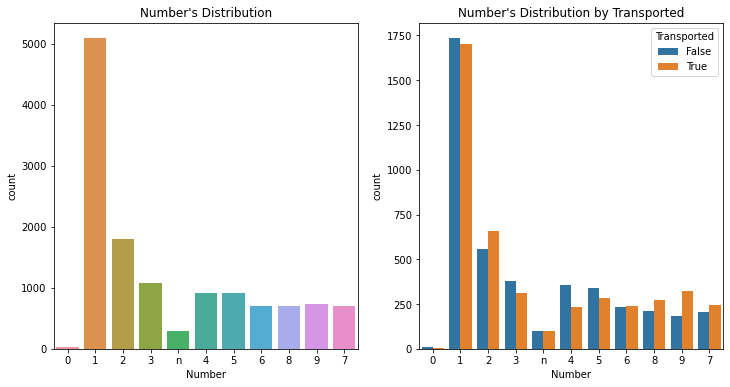

In [40]:
# Plot distribution and distribution by target. With help from Geunho's functions
feature = 'Number'
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title(f"{feature}'s Distribution")
sns.countplot(
    data=tmp,
    x=tmp[feature],
)
plt.subplot(1, 2, 2)
plt.title(f"{feature}'s Distribution by Transported")
sns.countplot(
    data=tmp,
    x=tmp[feature],
    hue='Transported',
)
;

''

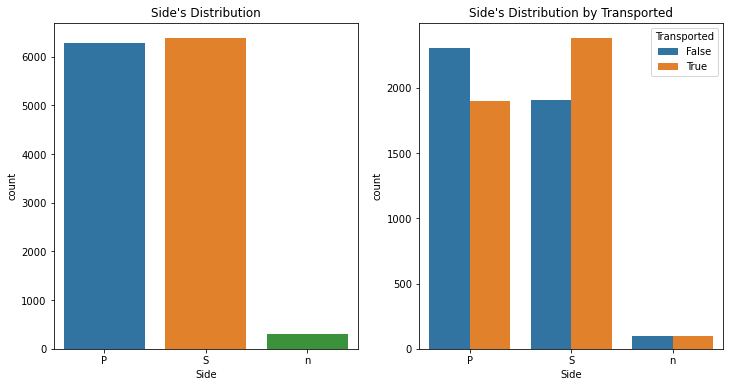

In [41]:
# Plot distribution and distribution by target. With help from Geunho's functions
feature = 'Side'
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title(f"{feature}'s Distribution")
sns.countplot(
    data=tmp,
    x=tmp[feature],
)
plt.subplot(1, 2, 2)
plt.title(f"{feature}'s Distribution by Transported")
sns.countplot(
    data=tmp,
    x=tmp[feature],
    hue='Transported',
)
;

#### Destination

''

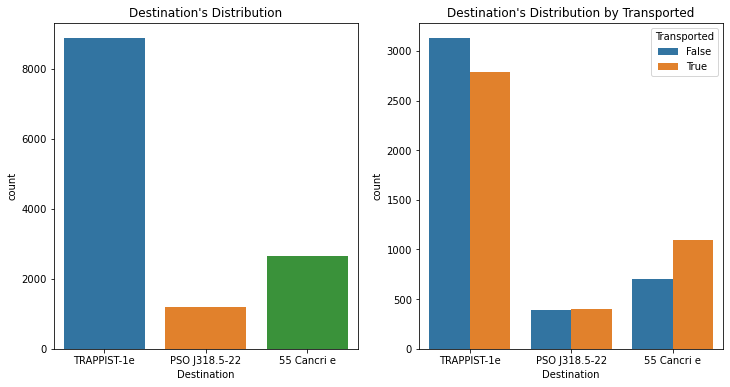

In [32]:
# Plot distribution and distribution by target. With help from Geunho's functions
feature = 'Destination'
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title(f"{feature}'s Distribution")
sns.countplot(
    data=data,
    x=data[feature],
)
plt.subplot(1, 2, 2)
plt.title(f"{feature}'s Distribution by Transported")
sns.countplot(
    data=data,
    x=data[feature],
    hue='Transported',
)
;

#### VIP

''

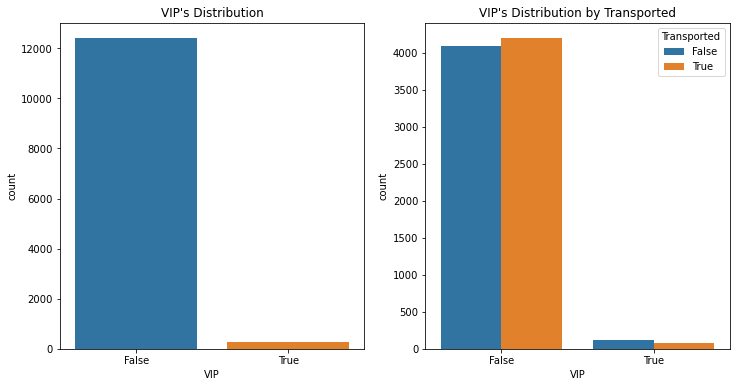

In [33]:
# Plot distribution and distribution by target. With help from Geunho's functions
feature = 'VIP'
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title(f"{feature}'s Distribution")
sns.countplot(
    data=data,
    x=data[feature],
)
plt.subplot(1, 2, 2)
plt.title(f"{feature}'s Distribution by Transported")
sns.countplot(
    data=data,
    x=data[feature],
    hue='Transported',
)
;

## Data Processing

To-do:
- ~~Fill missing values~~
- ~~Pclass to categorical~~
- ~~Age categories~~
- ~~Is in a family category. Large family, small family, no family~~

### Fill missing values

In [12]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [13]:
test.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

Fill Embarked missing values with mode. Only in training set

In [14]:
# Fill na in Embarked with mode
train.loc[train["Embarked"].isna(), "Embarked"] = train["Embarked"].mode()[0]
train['Embarked'].isna().sum()

0

As others have done, will fill missing Age values with the median age for the corresponding Pclass

In [15]:
# Fill na in Age with median by Pclass
median_ages = train.groupby(['Pclass']).median()
median_ages

,PassengerId,Survived,Age,SibSp,Parch,Fare
Pclass,,,,,,
1,472.0,1.0,37.0,0.0,0.0,60.2875
2,435.5,0.0,29.0,0.0,0.0,14.2500
3,432.0,0.0,24.0,0.0,0.0,8.0500


In [16]:
train.loc[(train['Age'].isna()) & (train['Pclass'] == 1), 'Age'] = median_ages.loc[1, 'Age']
train.loc[(train['Age'].isna()) & (train['Pclass'] == 2), 'Age'] = median_ages.loc[2, 'Age']
train.loc[(train['Age'].isna()) & (train['Pclass'] == 3), 'Age'] = median_ages.loc[3, 'Age']

In [17]:
# Fill na in Age with median by Pclass
median_ages = test.groupby(['Pclass']).median()
median_ages

,PassengerId,Age,SibSp,Parch,Fare
Pclass,,,,,
1,1094.0,42.0,0.0,0.0,60.0000
2,1122.0,26.5,0.0,0.0,15.7500
3,1091.5,24.0,0.0,0.0,7.8958


In [18]:
test.loc[(test['Age'].isna()) & (test['Pclass'] == 1), 'Age'] = median_ages.loc[1, 'Age']
test.loc[(test['Age'].isna()) & (test['Pclass'] == 2), 'Age'] = median_ages.loc[2, 'Age']
test.loc[(test['Age'].isna()) & (test['Pclass'] == 3), 'Age'] = median_ages.loc[3, 'Age']

In [19]:
train['Age'].isna().sum(), test['Age'].isna().sum()

(0, 0)

### Pclass to categorical

In [20]:
# With help from Aditya
train['Pclass'] = train['Pclass'].astype('category')
test['Pclass'] = test['Pclass'].astype('category')

### Age Groups
Will build an age group category for children (age < 18), adults (18 < age < 50) and seniors (50 < age)

In [21]:
train["Age_Group"] = train["Age"].map(
    lambda x: "child" if x < 18 else "adult" if x >= 18 and x < 50 else "senior"
)


In [22]:
test["Age_Group"] = test["Age"].map(
    lambda x: "child" if x < 18 else "adult" if x >= 18 and x < 50 else "senior"
)


### Family categories

In [23]:
train['SibSp'].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [24]:
train['Parch'].value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [25]:
train['family_members'] = train['SibSp'] + train['Parch']
test['family_members'] = test['SibSp'] + test['Parch']
train['family_members'].value_counts()

0     537
1     161
2     102
3      29
5      22
4      15
6      12
10      7
7       6
Name: family_members, dtype: int64

In [26]:
train.groupby('family_members').mean()['Survived']

family_members
0     0.303538
1     0.552795
2     0.578431
3     0.724138
4     0.200000
5     0.136364
6     0.333333
7     0.000000
10    0.000000
Name: Survived, dtype: float64

''

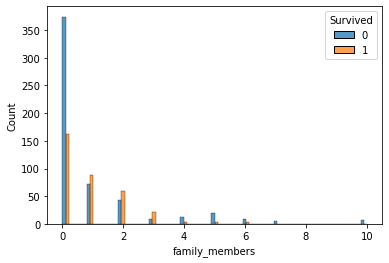

In [27]:
# Let's visualize family members by survival to decide where to divide the categories
sns.histplot(data=train, x=train["family_members"], hue=train["Survived"], multiple='dodge')
;

Family groups:
- 0 == none
- 1 to 3 == small
- 4 to 7 == large
- 8+ == super

In [28]:
train["Family_Group"] = train["family_members"].map(
    lambda x: "none"
    if x == 0
    else "small"
    if x >= 1 and x < 4
    else "large"
    if x >= 4 and x < 8
    else "super"
)
test["Family_Group"] = test["family_members"].map(
    lambda x: "none"
    if x == 0
    else "small"
    if x >= 1 and x < 4
    else "large"
    if x >= 4 and x < 8
    else "super"
)


### Sanity Check

In [29]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   PassengerId     891 non-null    int64   
 1   Survived        891 non-null    int64   
 2   Pclass          891 non-null    category
 3   Name            891 non-null    object  
 4   Sex             891 non-null    object  
 5   Age             891 non-null    float64 
 6   SibSp           891 non-null    int64   
 7   Parch           891 non-null    int64   
 8   Ticket          891 non-null    object  
 9   Fare            891 non-null    float64 
 10  Cabin           204 non-null    object  
 11  Embarked        891 non-null    object  
 12  Age_Group       891 non-null    object  
 13  family_members  891 non-null    int64   
 14  Family_Group    891 non-null    object  
dtypes: category(1), float64(2), int64(5), object(7)
memory usage: 98.6+ KB


In [30]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   PassengerId     418 non-null    int64   
 1   Pclass          418 non-null    category
 2   Name            418 non-null    object  
 3   Sex             418 non-null    object  
 4   Age             418 non-null    float64 
 5   SibSp           418 non-null    int64   
 6   Parch           418 non-null    int64   
 7   Ticket          418 non-null    object  
 8   Fare            417 non-null    float64 
 9   Cabin           91 non-null     object  
 10  Embarked        418 non-null    object  
 11  Age_Group       418 non-null    object  
 12  family_members  418 non-null    int64   
 13  Family_Group    418 non-null    object  
dtypes: category(1), float64(2), int64(4), object(7)
memory usage: 43.1+ KB


In [31]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_Group,family_members,Family_Group
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,adult,1,small
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,adult,1,small
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,adult,0,none
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,adult,1,small
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,adult,0,none


In [32]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_Group,family_members,Family_Group
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,adult,0,none
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,adult,1,small
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,senior,0,none
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,adult,0,none
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,adult,2,small


## X, y, validation split and baseline

In [33]:
# Target is the Survived column
y = train["Survived"]
y.value_counts(normalize=True)


0    0.616162
1    0.383838
Name: Survived, dtype: float64

Normalized value counts show a 38.38% survival rate, and our baseline is 61.62% accuracy!

In [34]:
# Features are Pclass, Sex, Embarked, Age group and Family group
X = pd.get_dummies(train[['Pclass', 'Sex', 'Embarked', 'Age_Group', 'Family_Group']])
X_test = pd.get_dummies(test[['Pclass', 'Sex', 'Embarked', 'Age_Group', 'Family_Group']])
X.head()

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Age_Group_adult,Age_Group_child,Age_Group_senior,Family_Group_large,Family_Group_none,Family_Group_small,Family_Group_super
0,0,0,1,0,1,0,0,1,1,0,0,0,0,1,0
1,1,0,0,1,0,1,0,0,1,0,0,0,0,1,0
2,0,0,1,1,0,0,0,1,1,0,0,0,1,0,0
3,1,0,0,1,0,0,0,1,1,0,0,0,0,1,0
4,0,0,1,0,1,0,0,1,1,0,0,0,1,0,0


In [35]:
X_test.head()

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Age_Group_adult,Age_Group_child,Age_Group_senior,Family_Group_large,Family_Group_none,Family_Group_small,Family_Group_super
0,0,0,1,0,1,0,1,0,1,0,0,0,1,0,0
1,0,0,1,1,0,0,0,1,1,0,0,0,0,1,0
2,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0
3,0,0,1,0,1,0,0,1,1,0,0,0,1,0,0
4,0,0,1,1,0,0,0,1,1,0,0,0,0,1,0


### Validation split

In [36]:
# Named test splits val for validation. Stratified since data is unbalanced
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, random_state=1331)

## Modeling

I'm going to Grid Search parameters for an XGBoost Classifier, ExtraTrees and RandomForest

### XGBoost
This code cell is commented out to be run only in Collab/Kaggle

In [37]:
# Instantiate classifier
xgb = XGBClassifier(use_label_encoder=False)
# Using same params as Dhruvin to start
params = {
    "max_depth": range(2, 10, 2),
    "n_estimators": range(26, 46, 2),
    "learning_rate": [0.2, 0.1, 0.03, 0.01],
}
# Instantiate Grid Search
xgb_gs = GridSearchCV(xgb, params, n_jobs=-1)
# Fit on training data
xgb_gs.fit(X_train, y_train)
# Save best estimator
xgb_best = xgb_gs.best_estimator_
# Return best parameters, validation score and training score
xgb_gs.best_params_, xgb_gs.score(X_val, y_val), xgb_gs.score(X_train, y_train)


({'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 30},
 0.8475336322869955,
 0.8203592814371258)

### Extra Trees

In [ ]:
# Instantiate classifier
et = ExtraTreesClassifier(n_jobs=-1)
# Using same params as Dhruvin to start
params = {
    "n_estimators": range(8, 28, 4),
    "max_depth": range(24, 48, 4),
    "max_leaf_nodes": range(20, 48, 4),
}
# Instantiate Grid Search
et_gs = GridSearchCV(et, params, n_jobs=-1)
# Fit on training data
et_gs.fit(X_train, y_train)
# Save best estimator
et_best = et_gs.best_estimator_
# Return best parameters, validation score and training score
et_gs.best_params_, et_gs.score(X_val, y_val), et_gs.score(X_train, y_train)


({'max_depth': 40, 'max_leaf_nodes': 44, 'n_estimators': 24},
 0.8475336322869955,
 0.8323353293413174)

### Random Forest

In [ ]:
# Instantiate classifier
rf = RandomForestClassifier(n_jobs=-1)
# Using same params as Dhruvin to start
params = {
    "n_estimators": range(2, 12, 2),
    "criterion": ["gini", "entropy"],
    "max_depth": range(2, 12, 2),
    "max_leaf_nodes": range(2, 20, 2),
}
# Instantiate Grid Search
rf_gs = GridSearchCV(rf, params, n_jobs=-1)
# Fit on training data
rf_gs.fit(X_train, y_train)
# Save best estimator
rf_best = rf_gs.best_estimator_
# Return best parameters, validation score and training score
rf_gs.best_params_, rf_gs.score(X_val, y_val), rf_gs.score(X_train, y_train)


({'criterion': 'gini',
  'max_depth': 4,
  'max_leaf_nodes': 18,
  'n_estimators': 10},
 0.8430493273542601,
 0.8188622754491018)

## Model Summary

## Submission

In [38]:
preds = xgb_best.predict(X_test)
submission = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived':preds})
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [40]:
submission.to_csv('/content/drive/MyDrive/kaggle/titanic/data/submission.csv', index=False)